In [1]:
# モジュールのインポート
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlibでの日本語表示用
from matplotlib import font_manager
fp = font_manager.FontProperties(fname="ipag.ttf")

# Q1 階層化クラスタリング

講義データについて講義名間の類似度(距離)に基づき講義を階層化クラスタリングすることを考える。

## Q1.1 特徴量ベクトル

以下のtfidf関数を作成する。このtfidf関数は、講義名のテキストデータと講義名に使われるキーワードのデータから、各講義のtfidfを行とする講義-単語行列を作成する関数。
このtfidf関数は、講義名を要素とするリストcources、キーワードを要素とするリストvocab、講義-単語行列(要素はtfidf値)を返す。

In [8]:
def tfidf():
    # keyword_list.csvの読み込み
    with open('keyword_list.csv', 'r',  encoding="utf-8") as f:
        vocab = [row[0] for row in  csv.reader(f)]

    # course_list.csvの読み込み
    with open('course_list.csv', 'r',  encoding="utf-8") as csvf:
        courses = [row[0] for row in  csv.reader(csvf)]

    # TFを要素とする講義-単語行列の作成
    tf = np.zeros((len(courses), len(vocab)), dtype=int)
    for i in range(len(courses)):
        for j in range(len(vocab)):
            if vocab[j] in courses[i]:
                tf[i, j]=courses[i].count(vocab[j])
        
    df=np.zeros(len(vocab))
    for j in range(len(vocab)):
        df[j] = len([k for k in tf[j] if k != 0])
    tfidf_mat = np.zeros((len(courses), len(vocab)))
    for i in range(len(courses)):
        for j in range(len(vocab)):
            tfidf_mat[i][j] =tf[i][j] * np.log(len(courses) / df[j])
                ### ヒント：上記の講義-単語行列の各列の非ゼロ要素の個数からその列に対応する単語のDFを求められる
        
    return  courses, vocab, tfidf_mat

courses, vocab, tfidf_matrix=tfidf()

similar_courses関数は入力の講義名に対してcos類似度に基づいて類似する講義名を探す関数であり、次の2つのリストを返す。

ind: 入力の講義および類似する講義のインデックスのリスト  
labels: 入力の講義名および類似する講義名のリスト

In [9]:
# cos類似度を求める関数（課題4参照）
def cos_sim(vec1, vec2):
    return np.dot(vec1, vec2)/np.sqrt(np.sum(vec1**2)*np.sum(vec2**2))

def similar_courses(target, tfidf_matrix, courses):
    ### 引数：
    # target: 入力講義のインデックス
    # tfidf_matrix: TFIDF値が要素の講義-単語行列
    # courses: 講義名のリスト

    ind = []# 入力講義または類似講義のインデックスのリスト
    labels = []# 入力講義名または類似講義名のリスト

    for i in range(tfidf_matrix.shape[0]):
        if cos_sim(tfidf_matrix[target], tfidf_matrix[i]) > 0:
            labels.append(courses[i])
            ind.append(i)
    return ind, labels

In [10]:
title="生態統計学" 
ind, labels=similar_courses(courses.index(title), tfidf_matrix, courses) 
print(len(ind))
# print(ind)
# print(labels)

100


In [14]:
tfidf_matrix[ind,:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

以下では、入力の講義についてsimilar_courses関数で取得した類似講義をデータセットとして、講義名間の類似度(距離)に基づきデータセットを階層化クラスタリングする。
クラスタリングにはscipyのクラスタリングモジュール(scipy.cluster.hierarchy)を用いる。
linkage関数は、特徴量ベクトルを行とする行列を入力とし、metric引数で指定した距離尺度とmethod引数で指定した距離計算方法で階層化クラスタリングを行い、特徴量ベクトル間のクラスタリングの過程を行列として返す。

以下では、linkage関数の入力をtfidf_matrix[ind,:]として、先に抽出した類似講義のTFIDFベクトルを行とする講義-単語行列を指定している。

dendrogram関数は、linkage関数が出力したクラスタリング過程を表す行列を入力として、クラスタリングの過程をデンドログラムとして可視化します。labels引数には各特徴量ベクトルに付与するラベルのリストを指定する。

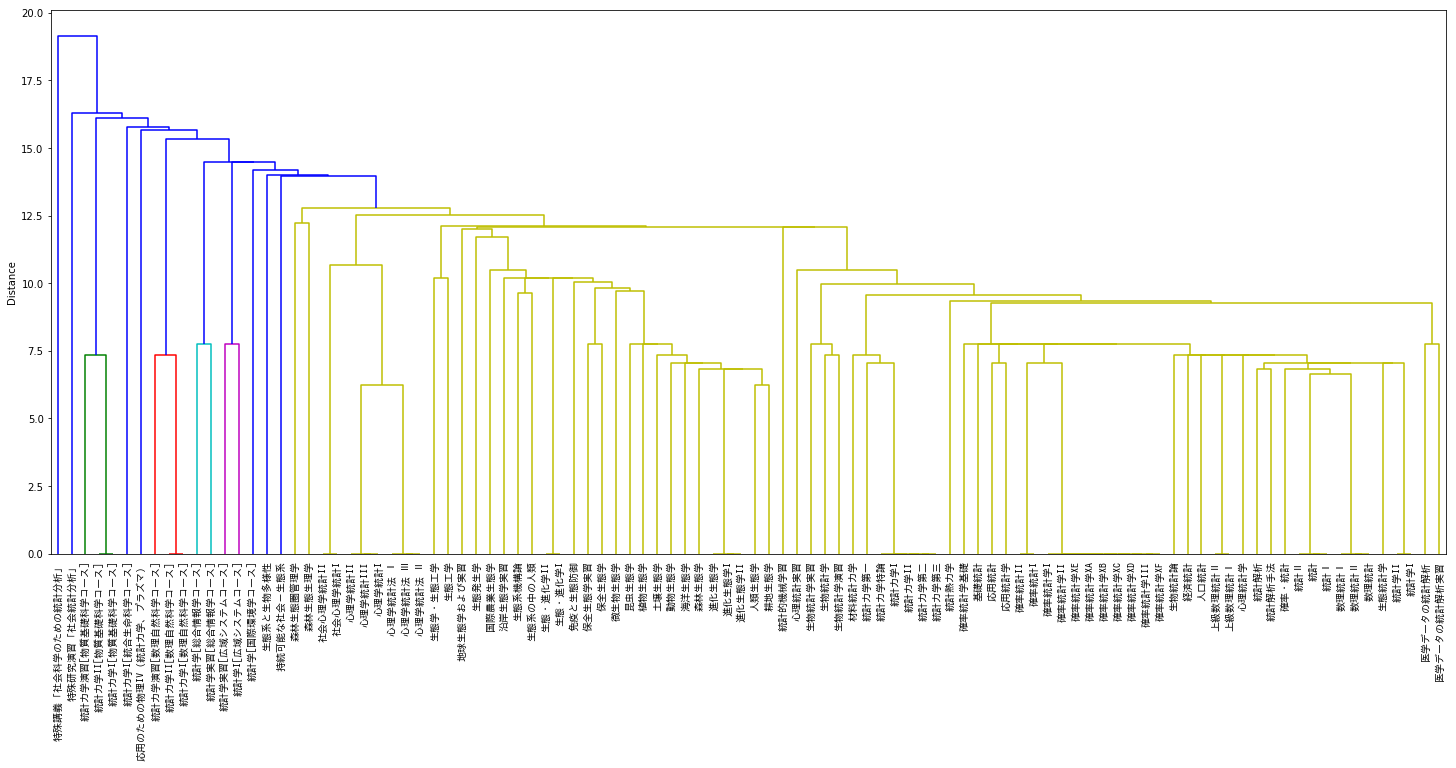

In [11]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

courses, vocab, tfidf_matrix=tfidf()
title="生態統計学" 
ind, labels=similar_courses(courses.index(title), tfidf_matrix, courses) 

# 階層化クラスタリング
# 距離尺度を'euclidean'、距離計算は'single'
clusters = linkage(tfidf_matrix[ind,:], metric = 'euclidean', method = 'single')

# デンドログラム
plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) # ラベルを日本語表示
plt.ylabel('Distance');

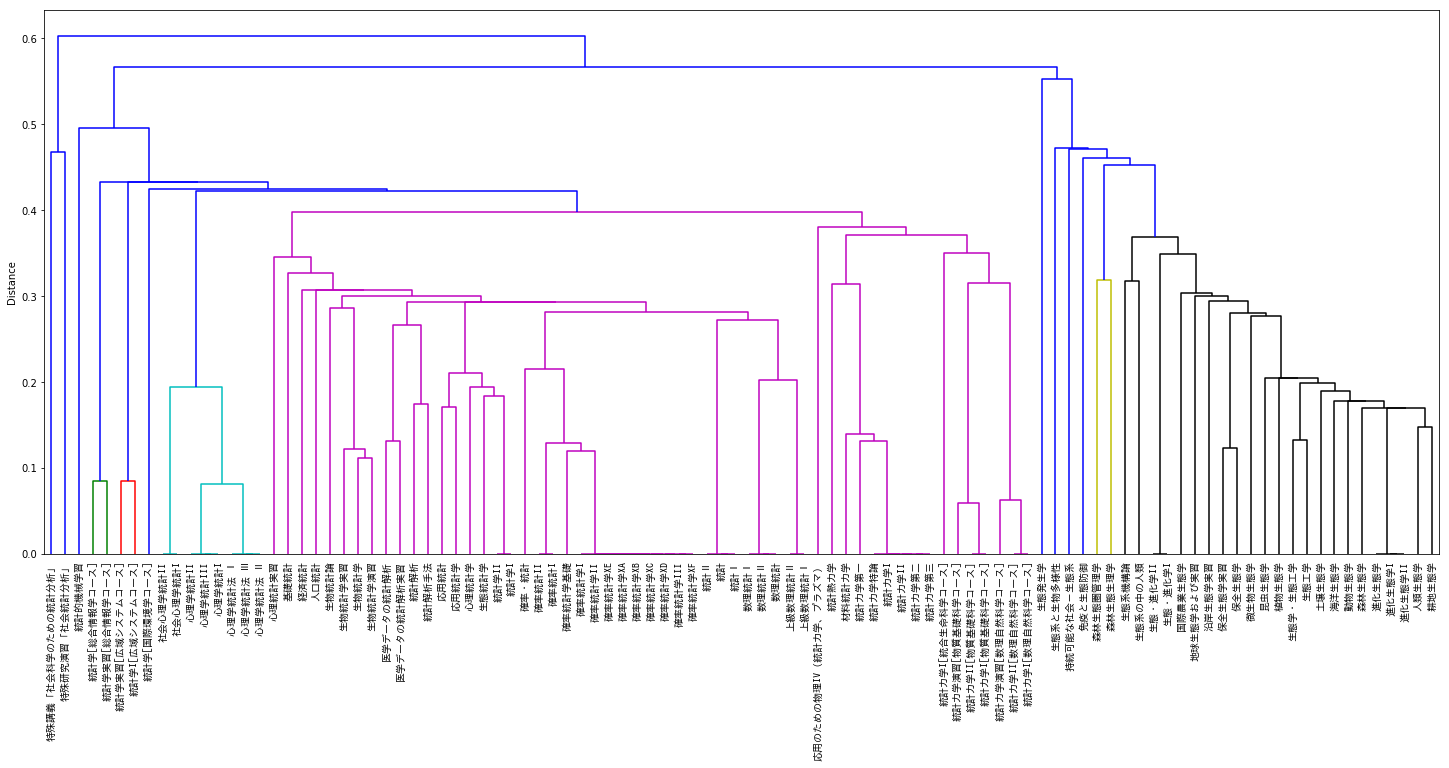

In [16]:
clusters =  linkage(tfidf_matrix[ind,:], metric = 'cosine', method = 'single')

plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) 
plt.ylabel('Distance');

linkage関数には、以下のように特徴量ベクトル間の距離を表す行列を入力することもできる。pdist関数はmetric引数で指定した特徴量ベクトル間の距離を計算し、それらの距離を要素とする行列を返す。距離行列をlinkage関数の入力とした場合は、linkage関数で距離尺度を指定する必要はない。

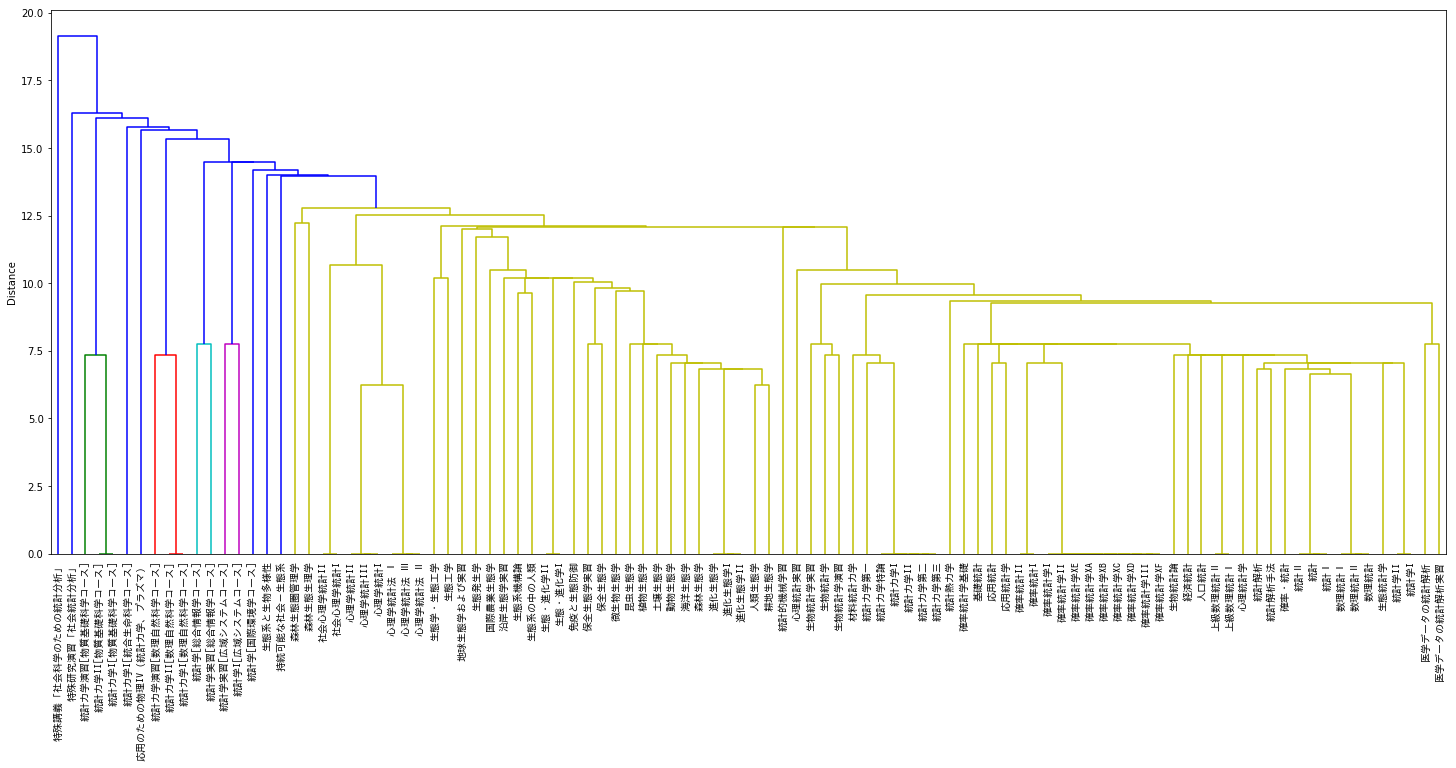

In [18]:
from scipy.spatial.distance import pdist

clusters = linkage(pdist(tfidf_matrix[ind,:], metric='euclidean'), method='single')

plt.figure(figsize=(25,10))
dend = dendrogram(clusters,  labels=labels)
for l in plt.gca().get_xticklabels(): l.set_fontproperties(fp) 
plt.ylabel('Distance');

In [19]:
from scipy.spatial.distance import squareform
# 距離行列
dist_matrix = pd.DataFrame(squareform(pdist(tfidf_matrix[ind,:], metric='euclidean')), columns=labels, index=labels)
dist_matrix

,生態統計学,心理統計学,心理統計実習,進化生態学I,統計力学演習[数理自然科学コース],確率統計II,統計力学II[数理自然科学コース],統計力学I[数理自然科学コース],進化生態学II,統計力学演習[物質基礎科学コース],...,森林生態圏管理学,植物生態学,土壌生態学,動物生態学,微生物生態学,森林生態生理学,昆虫生態学,森林生態学,保全生態学,生態系の中の人類
生態統計学,0.000000,10.180731,14.608635,14.144091,22.181131,14.358724,20.931038,20.931038,14.144091,22.732634,...,15.997688,14.608635,14.397728,14.253190,15.740068,17.483681,14.608635,14.144091,15.805327,13.719693
心理統計学,10.180731,0.000000,10.476877,17.427065,22.274283,14.502210,21.029728,21.029728,17.427065,22.823536,...,18.962418,17.806165,17.633543,17.515728,18.745587,20.231816,17.806165,17.427065,18.800416,17.084415
心理統計実習,14.608635,10.476877,0.000000,17.718955,22.503388,14.851697,21.272242,21.272242,17.718955,23.047182,...,19.231019,18.091940,17.922072,17.806165,19.017251,20.483778,18.091940,17.718955,19.071299,17.382061
進化生態学I,14.144091,17.427065,17.718955,0.000000,24.342385,17.513484,23.208996,23.208996,0.000000,24.845962,...,16.030254,10.327963,10.027420,9.818758,11.874524,17.513484,10.327963,9.659704,11.960893,13.757651
統計力学演習[数理自然科学コース],22.181131,22.274283,22.503388,24.342385,0.000000,22.341961,7.341268,7.341268,24.342385,16.952444,...,25.464140,24.615211,24.490630,24.405939,25.303086,26.423011,24.615211,24.342385,25.343732,24.098265
確率統計II,14.358724,14.502210,14.851697,17.513484,22.341961,0.000000,21.101398,21.101398,17.513484,22.889590,...,19.041871,17.890753,17.718955,17.601711,18.825954,20.306302,17.890753,17.513484,18.880550,17.172559
統計力学II[数理自然科学コース],20.931038,21.029728,21.272242,23.208996,7.341268,21.101398,0.000000,0.000000,23.208996,18.473754,...,24.382949,23.494987,23.364434,23.275644,24.214705,25.382697,23.494987,23.208996,24.257176,22.952825
統計力学I[数理自然科学コース],20.931038,21.029728,21.272242,23.208996,7.341268,21.101398,0.000000,0.000000,23.208996,18.473754,...,24.382949,23.494987,23.364434,23.275644,24.214705,25.382697,23.494987,23.208996,24.257176,22.952825
進化生態学II,14.144091,17.427065,17.718955,0.000000,24.342385,17.513484,23.208996,23.208996,0.000000,24.845962,...,16.030254,10.327963,10.027420,9.818758,11.874524,17.513484,10.327963,9.659704,11.960893,13.757651
統計力学演習[物質基礎科学コース],22.732634,22.823536,23.047182,24.845962,16.952444,22.889590,18.473754,18.473754,24.845962,0.000000,...,25.945954,25.113318,24.991220,24.908230,25.787909,26.887648,25.113318,24.845962,25.827793,24.606838


# scikit-learnライブラリ

以下は、scikit-learnライブラリのkMeansクラスを使ったクラスタリングについて。

In [20]:
from sklearn.datasets import load_iris
iris = load_iris() # データセットのロード
print(len(iris['data'])) # データの総数
print(iris['feature_names']) # 特徴量名
print(iris['data'][0:5]) # データ（先頭5行を表示）
print(iris['target_names']) # ラベル名
print(iris['target'][0:5], iris['target'][50:55], iris['target'][100:105]) # ラベル

150
['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
['setosa' 'versicolor' 'virginica']
[0 0 0 0 0] [1 1 1 1 1] [2 2 2 2 2]


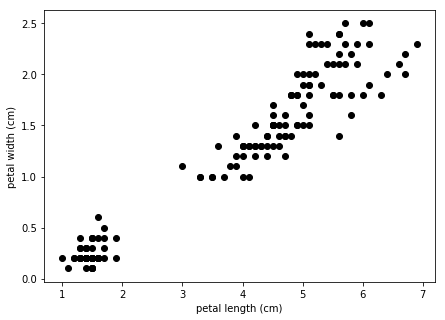

In [21]:
X_iris=iris['data'][:,2:4]
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
plt.scatter(X_iris[:,0],X_iris[:,1],c='black');

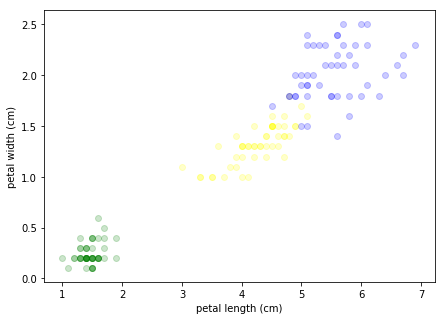

In [22]:
labels=iris['target']
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
plt.scatter(X_iris[labels==0,0],X_iris[labels==0,1],c='green', alpha=0.2)
plt.scatter(X_iris[labels==1,0],X_iris[labels==1,1],c='yellow', alpha=0.2)
plt.scatter(X_iris[labels==2,0],X_iris[labels==2,1],c='blue', alpha=0.2);

scikit-learnでは、以下の手順でデータからモデルの学習を行う。
- 使用するモデルのクラスの選択
- モデルのハイパーパラメータの選択とインスタンス化
- データの準備
    - 教師なし学習では、特徴量データを準備
- モデルをデータに適合（fit()メソッド）
- モデルの評価
    - 教師なし学習では、transform()またはpredict()メソッドを用いて特徴量データのクラスタリングや次元削減などを行う

31.38775897435898


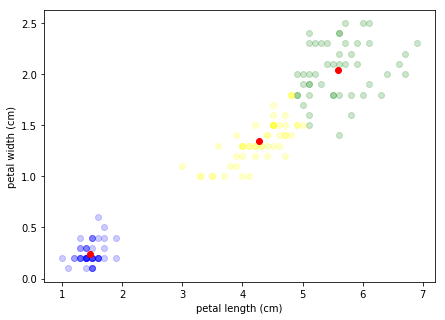

In [26]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3) 
model.fit(X_iris) 
clusters=model.predict(X_iris) 

# クラスタの可視化（irisデータセット、3クラスタ、特徴量2つを仮定）
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])

plt.scatter(X_iris[clusters==0,0],X_iris[clusters==0,1],c='blue', alpha=0.2)
plt.scatter(X_iris[clusters==1,0],X_iris[clusters==1,1],c='green', alpha=0.2)
plt.scatter(X_iris[clusters==2,0],X_iris[clusters==2,1],c='yellow', alpha=0.2)

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c='red'); # クラスタ中心
print(model.inertia_) # コスト関数の値

# Q2 kmeans法

## Q2.1 ユークリッド距離

In [27]:
def squared_euclid(x, y):
    return np.linalg.norm(x-y)

## Q2.2 k-means法

In [32]:
def kmeans(X, n_clusters, max_iter=10, rand_seed=0): 
    ### 引数：
    # X: 入力（データ数x特徴量数の行列）
    # n_clusters: クラスタ数
    # max_iter: 中心への割り当てと中心の更新の繰り返し数
    # rand_seed: 中心をランダムに選ぶ際のシード
    
    # クラスタ数のだけ中心を入力データからランダムに選ぶ
        # 補1: k-means++の場合は、この中心の選び方を変更
        # 補2: クラスタ数が比較的小さい時は異なる初期中心を試し
        # 最終的にコストが小さくなる初期中心を採用するのがよい
    np.random.seed(rand_seed)    
    centers=X[np.random.choice(X.shape[0],n_clusters),:] 
        
    # 入力データの各特徴量ベクトルと中心ベクトルの距離行列（入力データ数xクラスタ数）の初期化
    d = np.zeros((X.shape[0], n_clusters))
    
    # 各データの所属するクラスタ（中心）を表す配列
    clusters=np.zeros(X.shape[0])
    
    for l in range(max_iter): # max_iterだけ繰り返し
        # 1. 中心への割り当て
        for i in range(X.shape[0]):
            for k in range(n_clusters):
                d[i][k] =squared_euclid(X[i], centers[k])
                clusters[i] = np.argmin(d[i])
        
        # 2. 中心の更新
        for k in range(n_clusters):
            index_list = [idx for idx in range(X.shape[0]) if clusters[idx]==k]
            centers[k] = np.mean(X[index_list])
            plt.scatter(centers[k:,0], centers[k:,1], c='red')

    cost = np.sum((X - centers[np.argmin(d,axis=1),:])**2) # コストの計算
    print(cost)
    return clusters, centers, cost 

595.2856337821297
595.2856337821297


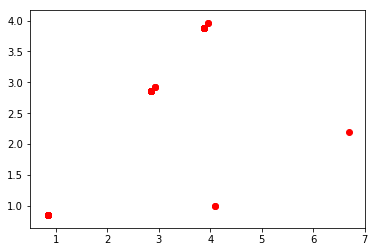

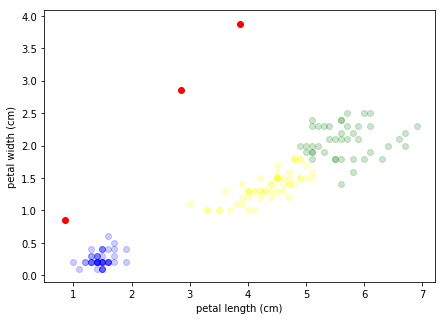

In [33]:
iris = load_iris() 
X_iris=iris['data'][:,2:4]
clusters, centers, cost=kmeans(X_iris, 3)
print(cost)

# クラスタの可視化（irisデータセット、3クラスタ、特徴量2つを仮定）
plt.figure(figsize=(7,5))
plt.xlabel(iris["feature_names"][2])
plt.ylabel(iris["feature_names"][3])
    
plt.scatter(X_iris[clusters==0,0],X_iris[clusters==0,1],c='blue', alpha=0.2)
plt.scatter(X_iris[clusters==1,0],X_iris[clusters==1,1],c='green', alpha=0.2)
plt.scatter(X_iris[clusters==2,0],X_iris[clusters==2,1],c='yellow', alpha=0.2)
plt.scatter(centers[:,0], centers[:,1], c='red'); # クラスタ中心

## Q2.3 エルボー法

クラスタリングにおいて、クラスタ数を変化させた時のクラスタリングのコストの変化に基づいて、最適なクラスタ数を決定する方法をエルボー法という。エルボー法では、クラスタ数を増やしていった時にコストが最も大きく減少する時のクラスタ数を採用する。以下のelbow関数は、Q2.2で作成したkmeans関数を用いて、クラスタ数を1から少しずつクラスタリングのコストの変化を可視化する。

1042.1634666666666
645.9256625074272
595.2856337821297
586.4777585858585
585.6675225787285


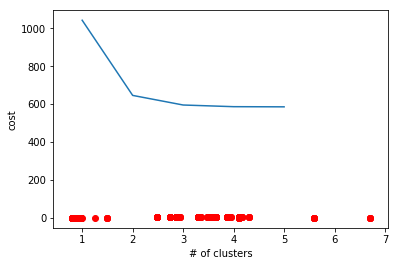

In [36]:
def elbow(X, K):
    ### 引数：
    # X: 入力データ
    # K: 最大のクラスタ数    
    
    # 各クラスタ数でのコストをいれるリスト
    costs=[]
    for k in range(1,K+1):
        clusters, centers, cost=kmeans(X_iris, k)
        costs.append(cost)
    # 1からKまでクラスタ数kのそれぞれで入力データをkmeans法でクラスタリングした時のコストを求めるコード
    # kmeans関数の引数はkmeans(X, k)のように与える

    # クラスタ数 vs. コストの可視化    
    plt.xlabel("# of clusters")
    plt.ylabel("cost")
    plt.plot(range(1,K+1),costs);

iris = load_iris() 
X_iris=iris['data'][:,2:4]
elbow(X_iris, 5)